In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold  # For spatial CV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer  # If needed
from libpysal.weights import KNN  # For spatial CV groups
import numpy as np
from scipy.spatial.distance import cdist
import rasterio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from libpysal.weights import KNN
from sklearn.model_selection import GroupKFold
import joblib
import shap
import folium


In [18]:
# Load processed GDF (from Phase 3)
full_gdf = gpd.read_file('data/processed/merged_gdf.geojson')  # Or CSV + add geometry

In [19]:
def sample_raster_with_buffer(raster_path, gdf, buffer_km=5):
    gdf['sampled_value'] = 0.0  # Initialize as float
    with rasterio.open(raster_path) as src:
        for idx, row in gdf.iterrows():
            if row.geometry is not None:
                geom_buffer = row.geometry.buffer(buffer_km / 111)  # Approx km to degrees
                coords = list(geom_buffer.exterior.coords)
                values = [val[0] for val in src.sample(coords) if not np.isnan(val[0])]
                gdf.at[idx, 'sampled_value'] = np.mean(values) if values else np.nan
    gdf['sampled_value'] = gdf['sampled_value'].astype('float64')  # Explicit cast
    return gdf['sampled_value']

In [20]:


full_gdf['rainfall'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\chirps_nigeria_monthly_mean_2018_2024.tif', full_gdf)
full_gdf['ndvi'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\ndvi_nigeria_mean_2018_2024_2.tif', full_gdf)
full_gdf['temp'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\temp_nigeria_monthly_mean_2018_2024.tif', full_gdf)
full_gdf['elevation'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\srtm_nigeria_elevation.tif', full_gdf)


# Population density (adjust for per km² if needed)
full_gdf['pop_density'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\nga_pd_2020_1km.tif', full_gdf)

# Distance to roads/water
roads_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\osm_roads_nigeria.geojson')
water_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\osm_water_nigeria.geojson')




In [21]:
# Define a projected CRS (UTM Zone 32N – good central choice for Nigeria)
projected_crs = 'EPSG:32632'

# Project all data
full_gdf_proj = full_gdf.to_crs(projected_crs)
roads_gdf_proj = roads_gdf.to_crs(projected_crs)
water_gdf_proj = water_gdf.to_crs(projected_crs)

# Compute distances (in km) – now accurate!
full_gdf_proj['dist_to_road'] = full_gdf_proj.geometry.apply(
    lambda geom: roads_gdf_proj.distance(geom).min() / 1000 
    if not geom.is_empty else np.nan
)
full_gdf_proj['dist_to_water'] = full_gdf_proj.geometry.apply(
    lambda geom: water_gdf_proj.distance(geom).min() / 1000 
    if not geom.is_empty else np.nan
)

# Urban index
full_gdf_proj['urban_index'] = full_gdf_proj['pop_density'] + full_gdf_proj['Nightlights_Composite']

In [22]:
# Add target if not present (align with paper: use prevalence instead of incidence for direct survey-based risk)
if 'malaria_risk' not in full_gdf_proj.columns:
    # Confirm required column exists (from covariates)
    if 'Malaria_Prevalence_2020' not in full_gdf_proj.columns:
        raise ValueError("Missing 'Malaria_Prevalence_2020' column in data—check covariates CSV.")
    mean_prev = full_gdf_proj['Malaria_Prevalence_2020'].mean()
    std_prev = full_gdf_proj['Malaria_Prevalence_2020'].std()
    full_gdf_proj['malaria_risk'] = (full_gdf_proj['Malaria_Prevalence_2020'] > mean_prev + std_prev).astype(int)
    print("Added 'malaria_risk' based on 'Malaria_Prevalence_2020'. Balance:", full_gdf_proj['malaria_risk'].value_counts(normalize=True))

Added 'malaria_risk' based on 'Malaria_Prevalence_2020'. Balance: malaria_risk
0    0.832049
1    0.167951
Name: proportion, dtype: float64


In [23]:
    # Bring everything back to original geographic CRS (EPSG:4326)
full_gdf = full_gdf_proj.to_crs(full_gdf.crs)  # All new columns are preserved!

# ——— SAVE BOTH FORMATS ———
# 1. GeoJSON → perfect for QGIS, Kepler.gl, GeoPandas plotting
full_gdf.to_file('data/processed/merged_gdf_with_phase2.geojson', driver='GeoJSON')

# 2. CSV → perfect for machine learning (scikit-learn, XGBoost, etc.)
full_gdf.to_csv('data/processed/merged_gdf_with_phase2_features.csv', index=False)

print("Saved both GeoJSON and CSV successfully!")
print(f"Final shape: {full_gdf.shape}")
print("Columns:", full_gdf.columns.tolist())

Saved both GeoJSON and CSV successfully!
Final shape: (1947, 165)
Columns: ['DHSID', 'GPS_Dataset', 'DHSCC_x', 'DHSYEAR_x', 'DHSCLUST_x', 'SurveyID', 'All_Population_Count_2000', 'All_Population_Count_2005', 'All_Population_Count_2010', 'All_Population_Count_2015', 'All_Population_Count_2020', 'Aridity_2000', 'Aridity_2005', 'Aridity_2010', 'Aridity_2015', 'Aridity_2020', 'Day_Land_Surface_Temp_2000', 'Day_Land_Surface_Temp_2005', 'Day_Land_Surface_Temp_2010', 'Day_Land_Surface_Temp_2015', 'Day_Land_Surface_Temp_2020', 'Diurnal_Temperature_Range_2000', 'Diurnal_Temperature_Range_2005', 'Diurnal_Temperature_Range_2010', 'Diurnal_Temperature_Range_2015', 'Diurnal_Temperature_Range_2020', 'Drought_Episodes', 'Elevation', 'Enhanced_Vegetation_Index_2000', 'Enhanced_Vegetation_Index_2005', 'Enhanced_Vegetation_Index_2010', 'Enhanced_Vegetation_Index_2015', 'Enhanced_Vegetation_Index_2020', 'Frost_Days_2000', 'Frost_Days_2005', 'Frost_Days_2010', 'Frost_Days_2015', 'Frost_Days_2020', 'Global

In [28]:
# Features from your data + paper (adjust if needed)
features = [
    'rainfall', 'ndvi', 'temp', 'elevation', 'pop_density', 'dist_to_road', 'dist_to_water', 'urban_index',
    'ITN_Coverage_2020', 'Precipitation_2020', 'Enhanced_Vegetation_Index_2020', 'Land_Surface_Temperature_2020',
    'Maximum_Temperature_2020', 'PET_2020', 'UN_Population_Density_2020'
]

In [34]:
X = full_gdf_proj[features].copy()  # Use projected GDF for consistency
y = full_gdf_proj['malaria_risk']   # Binary target (0/1)

# Handle missing values (impute with median, as in paper for robustness)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features, index=X.index)

# Scale features (standardize for better model performance)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=features, index=X.index)

print(f"Prepared X shape: {X_scaled.shape} | y balance: {y.value_counts(normalize=True)}")

Prepared X shape: (1947, 15) | y balance: malaria_risk
0    0.832049
1    0.167951
Name: proportion, dtype: float64


In [35]:
# Use states as groups (~37 unique > 5 splits; finer than zones)
if 'ADM1NAME' not in full_gdf_proj.columns:
    raise ValueError("Missing 'ADM1NAME'—check data merge.")
spatial_groups = pd.factorize(full_gdf_proj['ADM1NAME'])[0]  # Numeric labels (0-36ish)
print(f"Unique spatial groups (states): {len(np.unique(spatial_groups))}")

Unique spatial groups (states): 38


In [36]:
# Train-test split (80/20, stratified on y; respect groups roughly)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Models (hyperparams from paper/reference: balanced for imbalance)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=200, scale_pos_weight=(y==0).sum() / (y==1).sum(), random_state=42, n_jobs=-1)  # Handle imbalance

# Fit models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

print("Models trained!")

Models trained!


In [37]:
# Hold-out evaluation
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]

print("Hold-Out Test Performance:")
print(f"RF Accuracy: {accuracy_score(y_test, rf_pred):.3f} | AUC: {roc_auc_score(y_test, rf_proba):.3f}")
print(f"XGB Accuracy: {accuracy_score(y_test, xgb_pred):.3f} | AUC: {roc_auc_score(y_test, xgb_proba):.3f}")
print("\nXGB Classification Report:\n", classification_report(y_test, xgb_pred))
print("XGB Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

# Spatial CV (now uses the defined spatial_groups)
spatial_cv = GroupKFold(n_splits=5)
rf_cv_auc = cross_val_score(rf, X_scaled, y, cv=spatial_cv, groups=spatial_groups, scoring='roc_auc', n_jobs=-1)
xgb_cv_auc = cross_val_score(xgb, X_scaled, y, cv=spatial_cv, groups=spatial_groups, scoring='roc_auc', n_jobs=-1)

print("\nSpatial CV (5-Fold) AUC:")
print(f"RF: {rf_cv_auc.mean():.3f} ± {rf_cv_auc.std():.3f}")
print(f"XGB: {xgb_cv_auc.mean():.3f} ± {xgb_cv_auc.std():.3f}")

Hold-Out Test Performance:
RF Accuracy: 0.962 | AUC: 0.986
XGB Accuracy: 0.959 | AUC: 0.982

XGB Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       324
           1       0.89      0.86      0.88        66

    accuracy                           0.96       390
   macro avg       0.93      0.92      0.93       390
weighted avg       0.96      0.96      0.96       390

XGB Confusion Matrix:
 [[317   7]
 [  9  57]]

Spatial CV (5-Fold) AUC:
RF: 0.899 ± 0.052
XGB: 0.894 ± 0.058


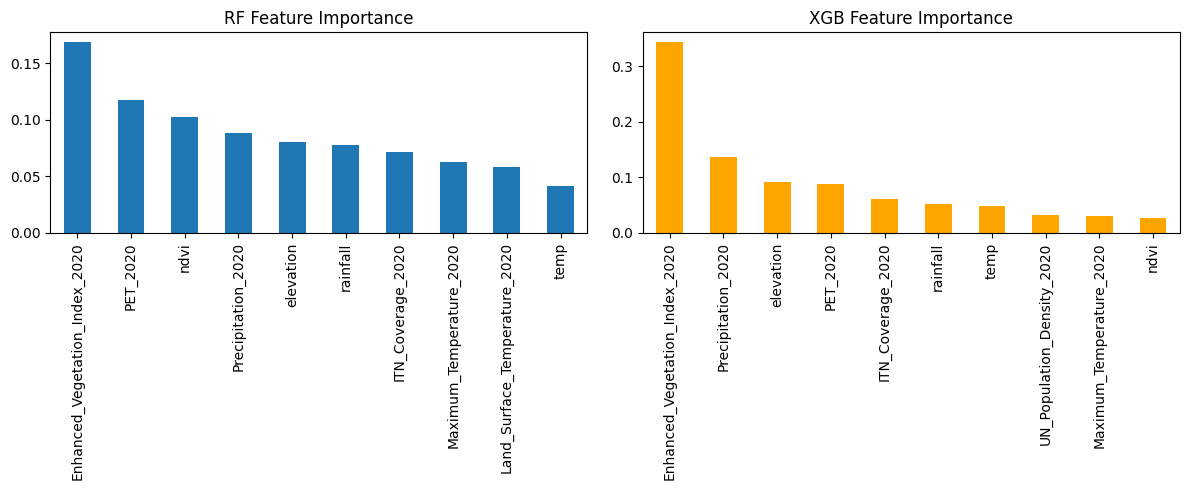

  0%|          | 0/1947 [00:00<?, ?it/s]

shap_values_pos shape: (1947, 15)
X_scaled shape: (1947, 15)
Number of features: 15


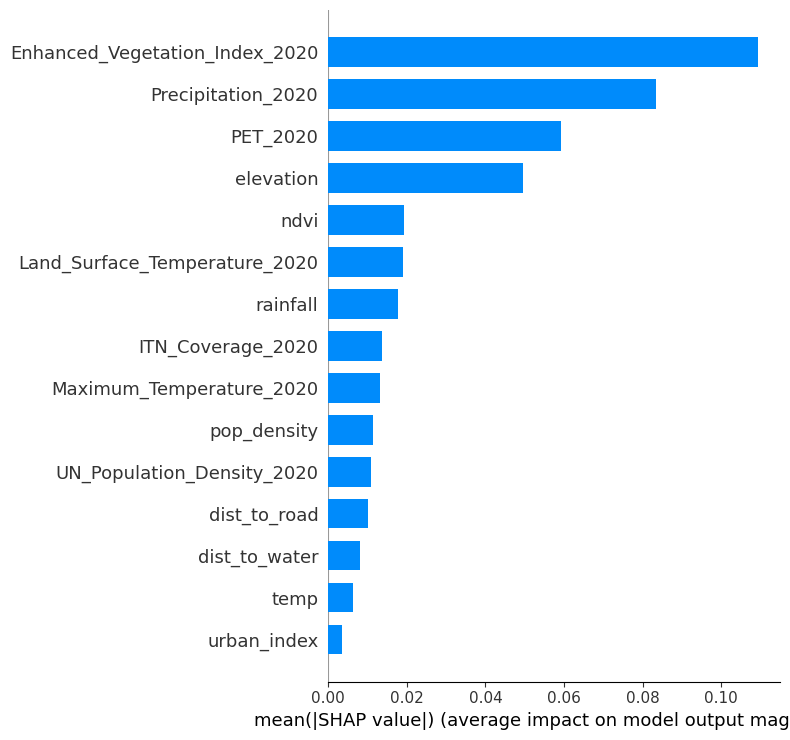

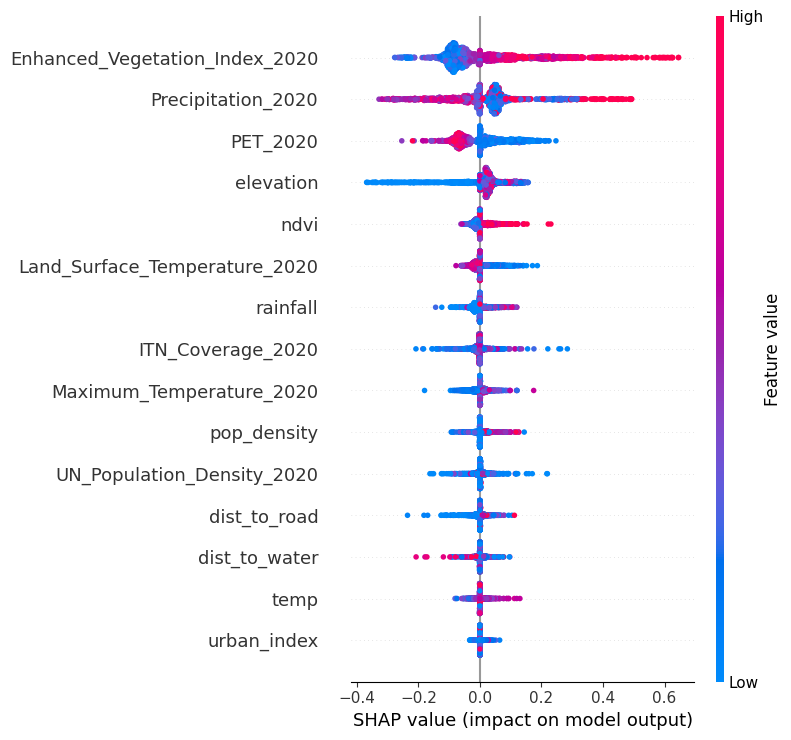

In [47]:
# Feature Importance (already working)
importances_rf = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importances_xgb = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
importances_rf.head(10).plot.bar(ax=ax1, title="RF Feature Importance")
importances_xgb.head(10).plot.bar(ax=ax2, title="XGB Feature Importance", color='orange')
plt.tight_layout()
plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\feature_importance.png')
plt.show()

# SHAP Workaround: Use KernelExplainer (slower but avoids TreeExplainer/XGBoost bug)
# Subsample background data for speed (use 100-200 rows; full if compute allows)
background_data = shap.kmeans(X_scaled.to_numpy(), 100).data  # Use .to_numpy() to avoid DF issues

# Wrap predict_proba in a lambda to avoid attribute setting issues on bound methods
model_fn = lambda x: xgb.predict_proba(x)
explainer = shap.KernelExplainer(model_fn, background_data)

# Compute SHAP values (nsamples='auto' or 100 for approx; increase for accuracy, but slow)
shap_values = explainer.shap_values(X_scaled.to_numpy(), nsamples=100)  # Use .to_numpy()

# For binary classification with KernelExplainer + predict_proba, shap_values is 3D: (n_samples, n_features, 2)
# Use [:, :, 1] for positive/high-risk class SHAP values
shap_values_pos = shap_values[:, :, 1]

# Optional: Debug shapes (remove after verifying)
print(f"shap_values_pos shape: {shap_values_pos.shape}")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"Number of features: {len(features)}")

# Summary bar plot (global importance)
shap.summary_plot(shap_values_pos, X_scaled.to_numpy(), feature_names=features, plot_type='bar', show=False)  # Pass feature_names explicitly
plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\shap_summary_bar.png')
plt.show()

# Full beeswarm summary (shows direction + magnitude)
shap.summary_plot(shap_values_pos, X_scaled.to_numpy(), feature_names=features, show=False)
plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\shap_summary_beeswarm.png')
plt.show()

In [51]:
import os
import joblib

# Ensure the models directory exists
models_dir = r'C:\Users\Hp\Documents\capstone_project\models'
os.makedirs(models_dir, exist_ok=True)

# Save XGBoost model pipeline
joblib.dump({'model': xgb, 'imputer': imputer, 'scaler': scaler, 'features': features}, 
            os.path.join(models_dir, 'xgb_pipeline.pkl'))

# Save Random Forest model pipeline
joblib.dump({'model': rf, 'imputer': imputer, 'scaler': scaler, 'features': features}, 
            os.path.join(models_dir, 'rf_pipeline.pkl'))

['C:\\Users\\Hp\\Documents\\capstone_project\\models\\rf_pipeline.pkl']

In [53]:
# Create grid (5km res, ~0.045 degrees)
grid_res = 0.045
lons = np.arange(2.5, 15, grid_res)  # Nigeria bounds
lats = np.arange(4, 14.5, grid_res)
grid_df = pd.DataFrame([(lon, lat) for lon in lons for lat in lats], columns=['lon', 'lat'])
grid_gdf = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']), crs='EPSG:4326')

# Sample features on grid (reuse your function; this may take time—parallelize if needed)
for feat, path in {'rainfall': r'C:\Users\Hp\Documents\capstone_project\data\raw\chirps_nigeria_monthly_mean_2018_2024.tif', 
                   'ndvi': r'C:\Users\Hp\Documents\capstone_project\data\raw\ndvi_nigeria_mean_2018_2024_2.tif', 
                    'temp': r'C:\Users\Hp\Documents\capstone_project\data\raw\temp_nigeria_monthly_mean_2018_2024.tif',
                     'elevation': r'C:\Users\Hp\Documents\capstone_project\data\raw\srtm_nigeria_elevation.tif',
                     'pop_density': r'C:\Users\Hp\Documents\capstone_project\data\raw\nga_pd_2020_1km.tif'
                  }.items():
    grid_gdf[feat] = sample_raster_with_buffer(path, grid_gdf)

# Add distances (project grid first)
grid_gdf_proj = grid_gdf.to_crs('EPSG:32632')
grid_gdf_proj['dist_to_road'] = grid_gdf_proj.geometry.apply(lambda g: roads_gdf_proj.distance(g).min() / 1000)
grid_gdf_proj['dist_to_water'] = grid_gdf_proj.geometry.apply(lambda g: water_gdf_proj.distance(g).min() / 1000)
grid_gdf_proj['urban_index'] = grid_gdf_proj['pop_density'] + grid_gdf_proj.get('Nightlights_Composite', 0)  # If available

# Predict (impute/scale first)
X_grid = grid_gdf_proj[features].copy()
X_grid_imputed = pd.DataFrame(imputer.transform(X_grid), columns=features)
X_grid_scaled = pd.DataFrame(scaler.transform(X_grid_imputed), columns=features)
grid_gdf_proj['risk_proba'] = xgb.predict_proba(X_grid_scaled)[:, 1]  # Probability as risk score

# Save and map
grid_gdf_proj.to_file('data/processed/risk_grid.geojson', driver='GeoJSON')

# Interactive Folium map (heat + choropleth)
m = folium.Map(location=[9.0, 8.5], zoom_start=6)  # Nigeria center
HeatMap(data=grid_gdf_proj[['lat', 'lon', 'risk_proba']], radius=15, blur=10).add_to(m)
folium.Choropleth(geo_data='data/raw/nigeria_states.geojson',  # Get from online if needed
                  data=grid_gdf_proj.dissolve(by='ADM1NAME', aggfunc='mean'),  # Aggregate by state
                  columns=['ADM1NAME', 'risk_proba'], key_on='feature.properties.name',
                  fill_color='YlOrRd', legend_name='Malaria Risk Probability').add_to(m)
m.save(r'C:\Users\Hp\Documents\capstone_project\data\outputs/risk_map.html')
print("Risk map saved—open in browser!")

KeyboardInterrupt: 

In [ ]:
# Assuming you add a 'historical_risk' column from external data
historical_acc = accuracy_score(full_gdf_proj['historical_risk'], xgb.predict(X_scaled))
print(f"Historical Match Accuracy: {historical_acc:.3f}")